# Inference-Based Methods for Aerodynamic and Propulsive Performance Estimation from Minimal Flight Test Data

by Peter Sharpe

## Introduction

One of the primary goals of an initial flight test of a new aircraft is to experimentally determine the aircraft's aerodynamic and propulsive performance characteristics.

The desired output of this process typically includes:
- The aircraft's aerodynamic polar, which gives the relationship between the aircraft's lift and drag coefficients.
- The aircraft's power curve, which gives the required power to maintain level flight as a function of airspeed.
- The aircraft's propulsive efficiency curve, which yields the overall propulsive efficiency, typically as a function of throttle setting and/or propeller advance ratio, if relevant.

All three of these results represent sweeps through the aircraft's flight envelope, varying the aircraft's airspeed, pitch trim setting, and throttle setting, and measuring the resulting lift, drag, and power required.

### Traditional Flight Test Measurement Methods

Typically, these performance outputs are obtained by performing an extensive campaign of careful, controlled flight experiments at quasi-steady flight conditions.

#### Aerodynamic Polar

For example, the aerodynamic polar is commonly measured by performing a series of long, steady power-off glides at different airspeeds. An implicit assumption here is that pitch trim is adjusted to maintain these airspeeds. Windmilling drag is also estimated and calibrated out, although this introduces significant uncertainty. The glide ratio (or equivalently, $L/D$) is then measured, yielding

$$(L/D) = \frac{h(t_1) - h(t_2)}{V \cdot (t_2 - t_1)}$$

where $h(t)$ represents the altitude at time $t$, and $V$ represents the airspeed. The drag is then computed as $D = W / (L/D)$, and $C_L$ and $C_D$ can be nondimensionalized from here.

#### Power Curve

Similarly, the power curve is often measured by flying in steady level flight for an extended period at a given airspeed, adjusting pitch trim as needed. The throttle setting is required, and this is then repeated for various airspeeds.

#### Propulsive Efficiency

The propulsive efficiency can be roughly estimated based on these experiments as well. One possible procedure is as follows:

1. The input power to the propulsion system $P_{\rm in}$ is measured at a given throttle setting. In a liquid-fueled airplane, this can be computing using the fuel flow rate at a given throttle setting (read off the panel via a fuel flow meter) and the specific energy of the fuel. For an electric airplane, one can measure the battery current and voltage.
2. We observe the steady-state climb/sink rate of the aircraft at this throttle setting and we compare this to the power-off sink rate. The difference between these two sink rates represents the air power done by the propulsion system. The air power can be computed as:

 $$P_{\rm air}=T \cdot V = m g \left( \frac{dh}{dt}\Big |_\text{power on} - \frac{dh}{dt}\Big |_\text{power off} \right)$$

3. Then, we can compute the propulsive efficiency as the ratio of the input power to the air power:

 $$\eta = \frac{P_{\rm air}}{P_{\rm in}}$$


### Limitations of Traditional Methods

Traditional methods for measuring aerodynamic and propulsive performance have several limitations. By far the biggest limitation is that they require vast amounts of flight time to obtain a sufficient number of data points to characterize the aircraft's performance. This is both expensive and time-consuming.

Furthermore, the aircraft must be flown at precisely-controlled conditions. This can be frustrating and tedious for the pilot, and it can also be dangerous if the aircraft is flown for an extended duration at conditions that are close to the edge of the flight envelope (e.g., behind the power curve on a not-yet-characterized experimental airplane).

Traditional methods also make no direct estimate of sensor noise (and hence, uncertainty) - data is collected and averaged until the experimenter is satisfied that the data is "good enough". This is a subjective process, and it is difficult to quantify the uncertainty in the resulting performance estimates.

Finally, traditional methods are not well-suited to estimating the performance of an aircraft that is not in steady flight. For example, data recorded during an aircraft's climb or descent to flight test altitude is typically discarded, which is wasteful; ideally, every single second of data should be used to refine our estimate of the aircraft's performance.

### Inference-Based Flight Testing Methods

By contrast, we propose a (new?) method of estimating these performance characteristics which relies on a fundamentally different perspective about flight testing. Traditionally, flight testing is viewed as a process of *pure measurement*, based only on analyzing the data itself. By contrast, we view the aircraft flight test as a *data-generating process*, from which we can *infer* performance relationships. This might sound like a small difference, but it allows us to recognize that we have more information than just the data itself:

- We know that the true state of the aircraft must follow Newtonian physics. This allows us to perform relatively robust correction for unsteady effects.
- We have some priors (e.g., informed guesses) about what the aircraft's aerodynamic and propulsive performance characteristics should be. Incorporation of physics-based performance models embeds our physical understanding of the aircraft into the estimation process, improving accuracy.

Finally, we can also make advances at the level of the sensor data by rigorously estimating the sensor noise *using the data itself*, which allows cleaner data inputs to this entire model. The following figure illustrates our proposed approach:

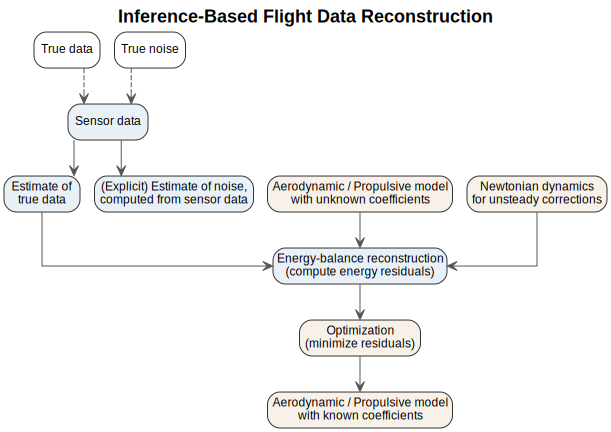

In [1]:
import graphviz

gv_settings = dict(
    graph_attr=dict(
        rankdir='TB',
        nodesep='0.2',
        bgcolor='#FFFFFF',
        splines='ortho',
    ),
    node_attr=dict(
        shape='box',
        style='rounded,filled',
        fillcolor='#E9F1F7',
        fontname='Helvetica',
        fontsize='12',
        color='#333333',
    ),
    edge_attr=dict(
        arrowhead='vee',
        arrowtail='none',
        fontname='Helvetica',
        fontsize='10',
        color='#555555',
    ),
)

g = graphviz.Digraph(**gv_settings)

title_style = dict(fontname='Helvetica-Bold', fontsize='16', shape='plaintext')
hidden_style = dict(fillcolor='white')
model_style = dict(fillcolor='#F7F1E9')

# Create a node for the title
g.attr(
    label="Inference-Based Flight Data Reconstruction",
    labelloc="t",
    fontname='Helvetica-Bold', fontsize='18', shape='plaintext'
)

g.node("true", label="True data", **hidden_style)
g.node("sensor", label="Sensor data")
g.node("noise", label="True noise", **hidden_style)
g.node("estimate", label="Estimate of\ntrue data")
g.node("noise_estimate", label="(Explicit) Estimate of noise,\ncomputed from sensor data")

g.edge("true", "sensor", style='dashed')
g.edge("noise", "sensor", style='dashed')

g.edge("sensor", "estimate")
g.edge("sensor", "noise_estimate")

g.node("model_unsolved", label="Aerodynamic / Propulsive model\nwith unknown coefficients", **model_style)
g.node("newton", label="Newtonian dynamics\nfor unsteady corrections", **model_style)

g.node("energy_balance", label="Energy-balance reconstruction\n(compute energy residuals)")

g.node("opti", label="Optimization\n(minimize residuals)", **model_style)

g.node("model_solved", label="Aerodynamic / Propulsive model\nwith known coefficients", **model_style)

g.edge("newton", "energy_balance")
g.edge("estimate", "energy_balance")
g.edge("model_unsolved", "energy_balance")

g.edge("energy_balance", "opti")

g.edge("opti", "model_solved")

g

## A Minimal Flight Test Dataset

To illustrate our proposed flight test procedure, we use data from a recent flight test during MIT 16.821: Flight Vehicle Development, a senior-level aircraft design/build/fly capstone course at MIT AeroAstro. The flown aircraft, named *Solar Surfer*, is a remote-controlled solar-electric seaplane design with a 14-foot wingspan. The as-flown all-up mass is 9.4 kg.

<div style="text-align: center;">
  <img src="./assets/Flight1_02549.JPG" alt="flight-pic" style="max-width: 40%;">
</div>

General details of the aircraft configuration can be found in an early design drawing, shown below. This drawing does not reflect as-built weights or various planform adjustments that were made during preliminary design and construction.

<div style="text-align: center;">
  <img src="./assets/seaway_mini_packet_Page_1.png" alt="drawing" style="max-width: 80%;">
</div>

The aircraft was flown in the vicinity of the Charles river basin near Cambridge, MA. Five tests were conducted on the morning of May 3, 2023, of which two were flight tests. The final flight test lasted approximately 260 seconds (4.3 minutes), beginning and ending with a successful water takeoff and landing.

A simple racetrack-like pattern was flown, as shown in the figure below. Winds were calm at roughly 1.5 m/s from the south.

<div style="text-align: center;">
    <img src="./assets/flight3-circuit.png" alt="path" style="max-width:60%;">
</div>

The following relevant sensors were on-board the aircraft:
* A 9-DOF IMU (accelerometer, gyroscope, magnetometer), logging at 2 Hz
* A pitot-static probe, logging at 5 Hz
* A barometric altimeter, logging at 5 Hz
* A GPS, logging at approximately 2 Hz, with a few delayed or missed samples
* A battery voltage and current monitor, logging at 5 Hz

Below is an example view of the raw data from the sensors during the flight:

In [2]:
# Set up general imports and locate data sources

import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
import pandas as pd
from scipy import interpolate

timestamp_0 = 539330432

raw_time_takeoff = 577
raw_time_landing = 840

t_max = raw_time_landing - raw_time_takeoff

data_sources = {
    "airspeed"  : ("./data/flight3_airspeed_validated_0.csv", "calibrated_airspeed_m_s"),
    "barometer" : ("./data/flight3_sensor_baro_0.csv", "pressure"),
    "baro_alt"  : ("./data/flight3_vehicle_air_data_0.csv", "baro_alt_meter"),
    "gps_alt_mm": ("./data/flight3_vehicle_gps_position_0.csv", "alt"),
    "voltage"   : ("./data/flight3_battery_status_1.csv", "voltage_v"),
    "current"   : ("./data/flight3_battery_status_1.csv", "current_a"),
}

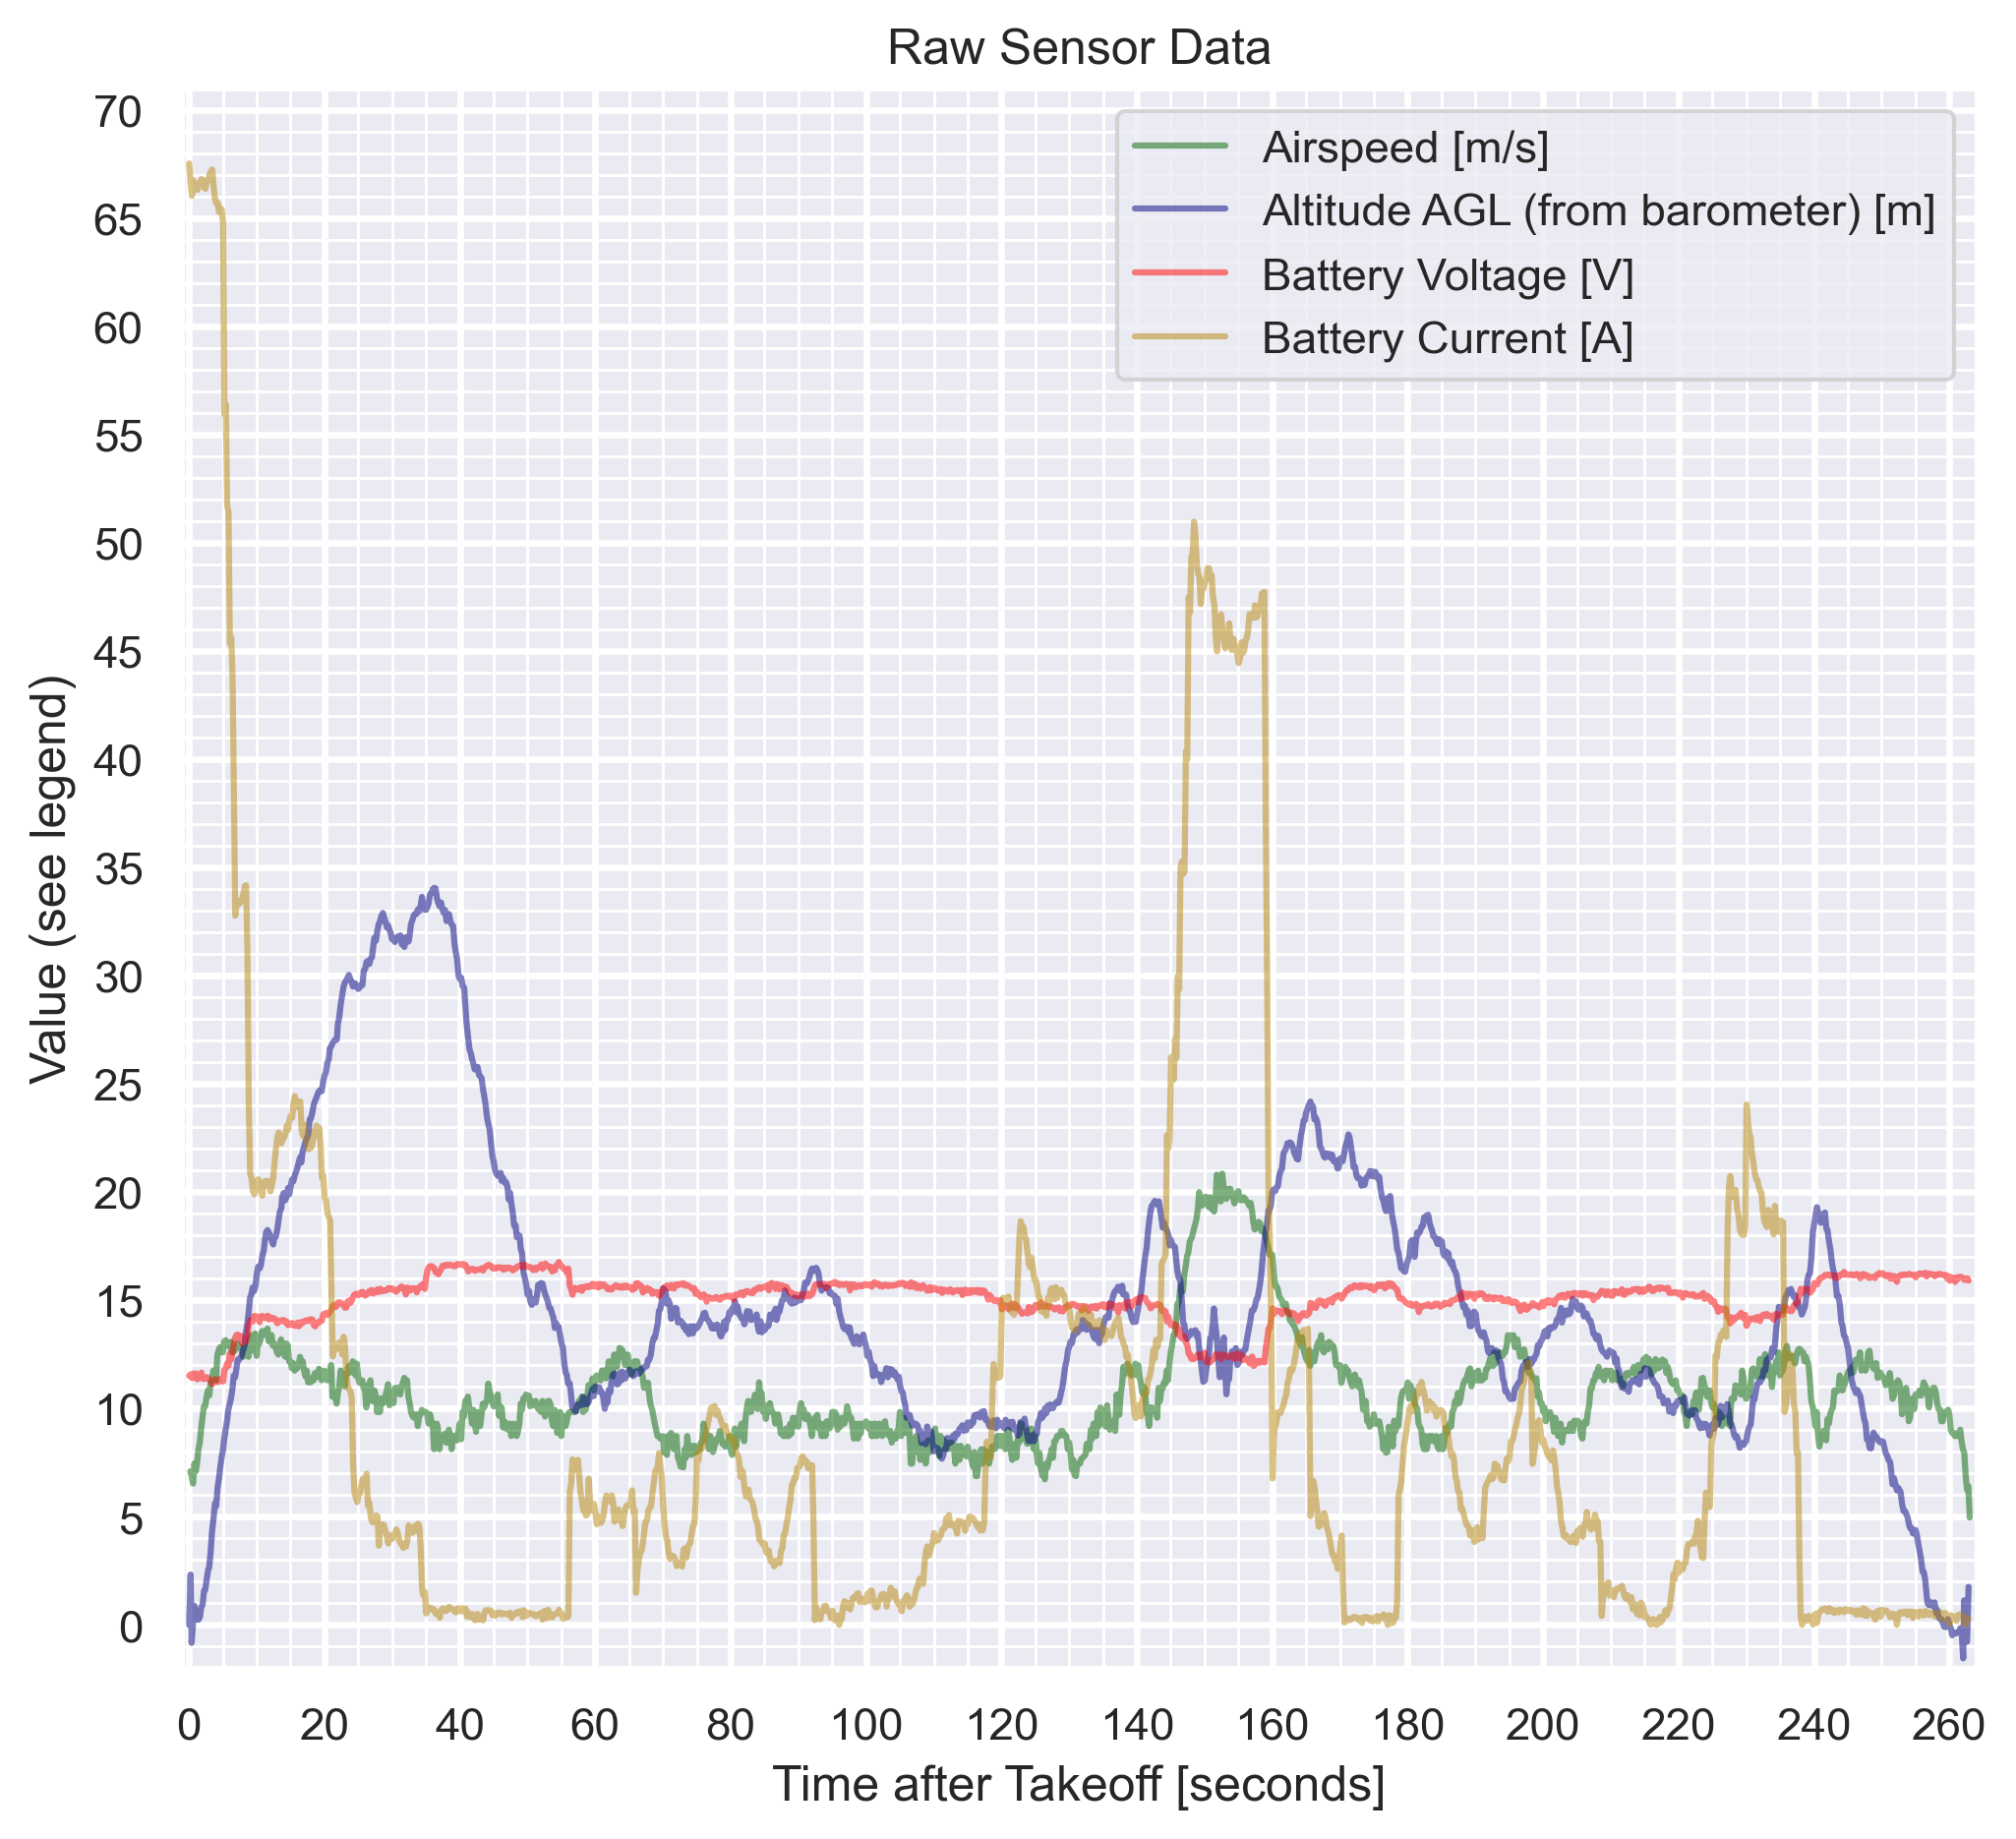

In [3]:
fig, ax = plt.subplots(figsize=(7, 6.4))

speed_color = "darkgreen"
alt_color = "navy"
voltage_color = "red"
current_color = "darkgoldenrod"


def simple_read(name):
    source = data_sources[name][0]
    colname = data_sources[name][1]

    df = pd.read_csv(source)

    raw_time = (df["timestamp"].values - timestamp_0) / 1e6
    data = df[colname].values

    mask = (raw_time > raw_time_takeoff) & (raw_time < raw_time_landing)

    time = raw_time[mask] - raw_time_takeoff
    data = data[mask]

    return time, data


plt.plot(
    *simple_read("airspeed"),
    color=speed_color, alpha=0.5,
    label="Airspeed [m/s]"
)
baro_data = simple_read("baro_alt")
baro_altitude_at_takeoff = baro_data[1][0]
plt.plot(
    baro_data[0], baro_data[1] - baro_altitude_at_takeoff,
    color=alt_color, alpha=0.5,
    label="Altitude AGL (from barometer) [m]"
)
plt.plot(
    *simple_read("voltage"),
    color=voltage_color, alpha=0.5,
    label="Battery Voltage [V]"
)
plt.plot(
    *simple_read("current"),
    color=current_color, alpha=0.5,
    label="Battery Current [A]"
)

plt.xlabel("Time after Takeoff [seconds]")
plt.ylabel("Value (see legend)")
plt.title("Raw Sensor Data")
p.set_ticks(20, 5, 5, 1)
plt.xlim(-1, t_max + 1)
plt.ylim(bottom=-2)
p.show_plot(
    dpi=300
)

Overall, the data is reasonable, and we can clearly identify takeoff and landing by the strong increase in barometric altimeter noise near $t=0\ \rm sec$ and $t=263\ \rm sec$. We can also identify several flight phases: a high-speed pass that was conducted near $t=150\ \rm sec$, and gliding periods near $t=50\ \rm sec$, $t=210\ \rm sec$, and $t=250\ \rm sec$.

There are two major problems with the data we have. Firstly, all of the data sources, and in particular the airspeed sensor, yield noisy measurements. This will later become a significant issue that we must solve, since unsteady corrections require taking the derivative of noisy data.

Secondly, the total amount of data is extremely limited, both in duration and sample rate. For example, there are only ~1200 data points **in total** for each of the plotted sensor traces, and this is before eliminating noise. After eliminating noise (which effectively acts as a low-pass filter on our data, as noise tends to be relatively high-frequency), the effective amount of information we have from the sensors is extremely low.

Consider that even the most sophisticated techniques for system identification via statistical inference require the system to be observable in some form - no amount of math can recover a signal that is simply not present in the data. This is difficult, because after noise removal, the data really no more than perhaps a half-dozen "system excitations" from which we can infer aircraft performance. As a more intuitive analogy, consider that even the world's best test pilot can't accurately characterize the handling qualities of the aircraft without observing at least a few flight maneuvers.

For these reasons, this dataset makes a good example case for what kinds of flight data reconstruction are possible with extremely limited, noisy data using statistical inference techniques.

## Sensor Data Pre-Processing

The first contribution here is to develop a (new?) means of pre-processing the sensor data. Traditionally, noise is removed by simple averaging. This works fine for traditional steady analysis where there is a wealth of data that we can average over.

However, in cases where data is limited, we need to find a way to use unsteady data. This is difficult, because it forces us to directly deal with the bias-variance tradeoff of data, rather than handwaving it away by averaging.

The other complicating factor here is that the unsteady equations of motion will use not just the airspeed and altitude values, but also their first derivatives. Hence, any error in our estimate of the true signal will be magnified by the derivative operation.

As an illustrative example, imagine that we wish to reconstruct a *truth* estimate of the airspeed from the example dataset. This truth value is not directly observable, although data from an associated airspeed sensor is. However, this sensor data has noise; so any attempt to reconstruct the truth value must adopt a strategy to separating the noise from the data.

However, there are (literally) an infinite number of possible strategies that one can use to do this noise removal. Which of the following possible curves best estimates the true underlying state of the vehicle?

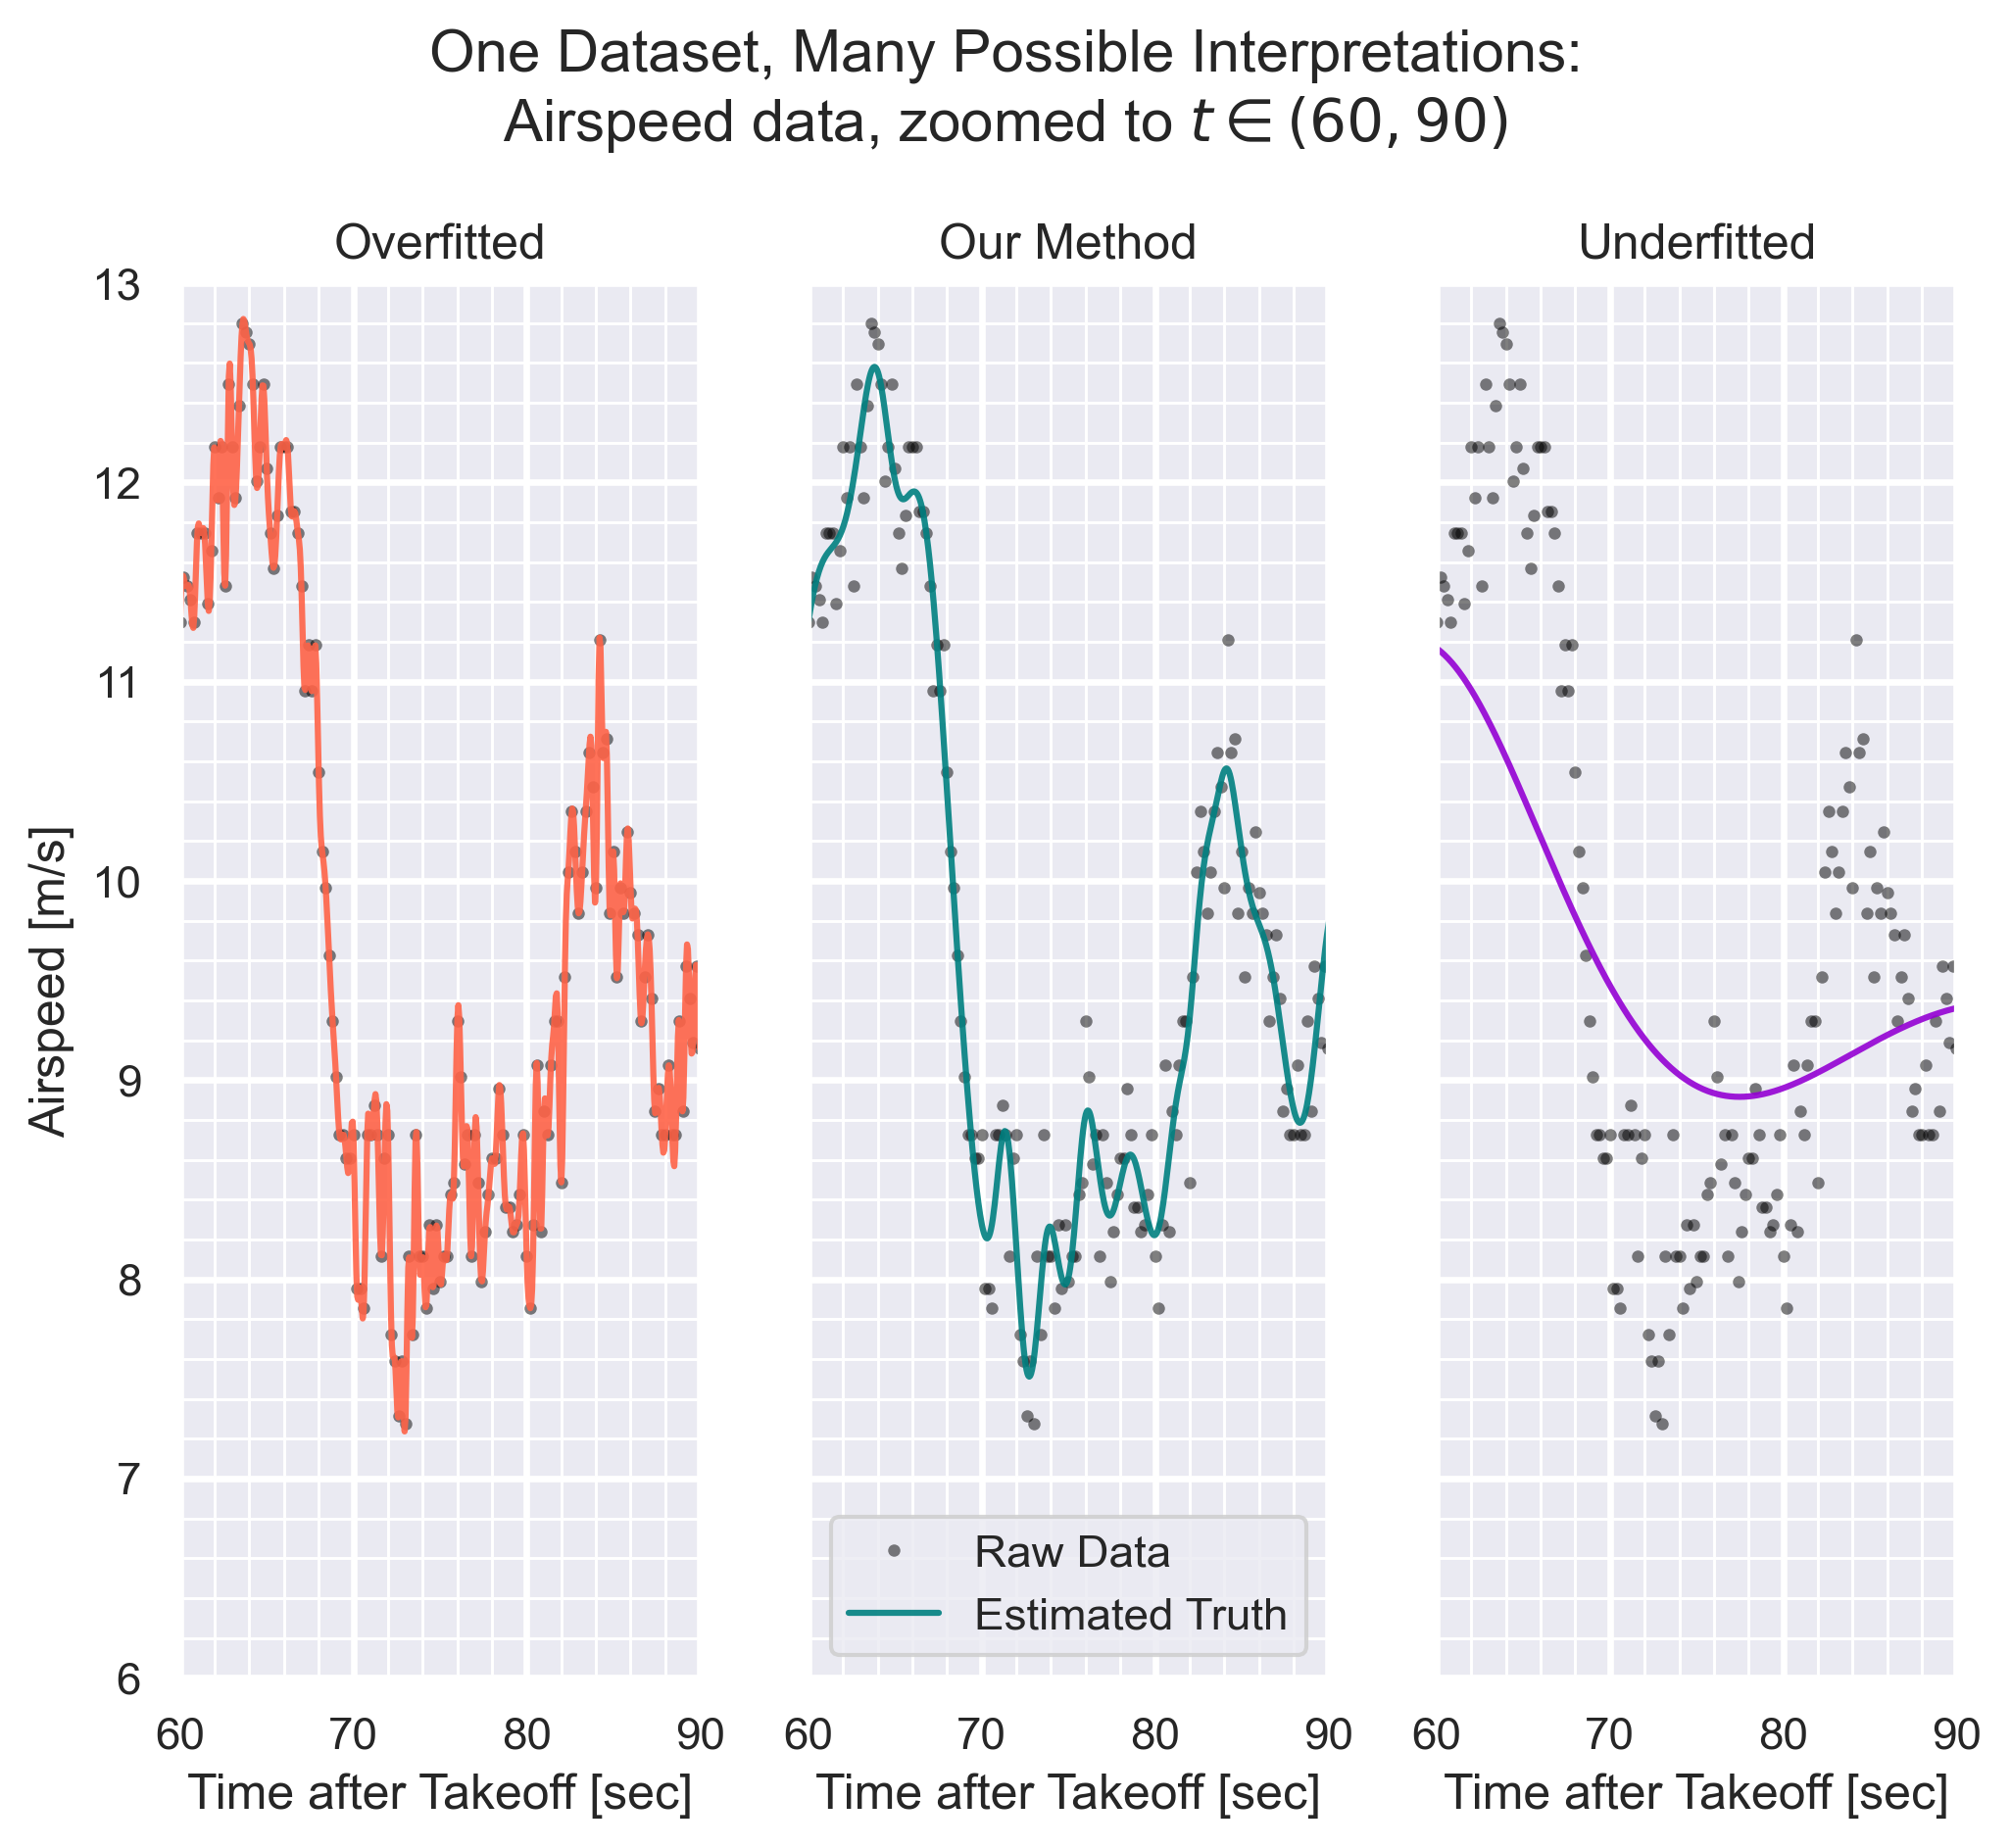

In [4]:
t, a = simple_read("airspeed")

assumed_stdev = [
    0,
    np.std(np.diff(np.diff(a))) / np.sqrt(6),
    0.8
]
colors = [
    "tomato",
    "teal",
    "darkviolet"
]
names = [
    "Overfitted",
    "Our Method",
    "Underfitted"
]

estimators = [
    interpolate.UnivariateSpline(
        x=t,
        y=a,
        k=5,
        w=1 / s * np.ones_like(a) if s > 0 else None,
        s=len(a) if s > 0 else 0,
        check_finite=True,
        ext='raise'
    )
    for s in assumed_stdev
]

fig, ax = plt.subplots(
    1, len(assumed_stdev), figsize=(7, 6.4),
    sharey=True
)

for i in range(len(assumed_stdev)):
    plt.sca(ax[i])
    plt.plot(
        t, a,
        ".k",
        label="Raw Data",
        alpha=0.5,
        markersize=6,
        markeredgewidth=0
    )

    n = names[i]
    t_plot = np.linspace(t[0], t[-1], 5000)
    plt.plot(
        t_plot,
        estimators[i](t_plot),
        label="Estimated Truth",
        alpha=0.9,
        color=colors[i]
    )

    xlim = (60, 90)
    plt.xlim(*xlim)
    plt.ylim(6, 13)
    plt.title(n)
    plt.xlabel("Time after Takeoff [sec]")
    if i == 0:
        plt.ylabel("Airspeed [m/s]")
    p.set_ticks(10, 2, 1, 0.2)
    if i == 1:
        plt.legend()

plt.suptitle(f"One Dataset, Many Possible Interpretations:\nAirspeed data, zoomed to $t \in {xlim}$")

p.show_plot(
    legend=False,
    dpi=300,
)

Ultimately, all three charts represent different *interpretations of the ground truth based on the data*. If we didn't have any more information about the problem, all three could be equally justifiable given the right contexts - but, in fact, we do have more information, since we know this data originates from a physical system.

The chart on the left is clearly overfitted (i.e., tracks the data too closely) based on engineering intuition. Essentially, we are assuming that each sample is the true data, and that each sample has no noise; hence, the "truth" curve exhibits extremely high variance (strong wiggles). There's no *mathematical* reason why this interpretation can't be correct (it's theoretically possible that the sensor is giving perfect information), but of course it is *physically* implausible for our system. If this interpretation were true, it would imply that the vehicle is achieving velocity-vector-aligned-accelerations on the order of:

In [5]:
print("Peak instantaneous x-acceleration:",
      f"{np.abs(estimators[0].derivative()(t)).max() / 9.81:.2f} G")

Peak instantaneous x-acceleration: 2.42 G


which is obviously not physically possible.

The chart on the right is clearly underfitted (i.e., tracks the data too slowly), as there are large regions where the estimator has a consistent bias (e.g., consistently too high or low) with respect to the underlying data. It might seem like there are no contexts where such an interpretation would be reasonable, but that is not necessarily the case. For example, if the sensor noise at each sample was not independent, but rather correlated with noise from the previous samples, we might not be able to rule out this interpretation of reality.

Of course, a quick glance at the three charts above would tell us "the middle one looks about right" - but why? What is it about the middle chart that makes it look more reasonable than the other two?


### Optimal Sensor Data Reconstruction using Data-Driven Noise Estimates

The key difference is that the middle chart embeds certain intuitive assumptions that we "just know" about our data into its reconstruction. Specifically, the middle chart is an optimal reconstruction of the data assuming that:
- The noise in each sample is independent (i.e., uncorrelated with previous samples) and normally-distributed
- The noise is unbiased (i.e., there are no systematic errors in the data, only random ones)
- The noise is homoscedastic (i.e., the standard deviation of the noise is constant across the entire dataset)
- The sample rate is significantly higher than the underlying dynamics of the system that we're aiming to recover (i.e., the system is "slow" relative to the sample rate).

Under these assumptions above, the probabilistic properties of the noise reduce to a single parameter: the variance (that is, the square of the standard deviation, $\sigma^2$) of the noise.

#### Motivation for Finding the Variance of the Noise

Because we're just one parameter away from having a probabalistic model of the sensor noise, we're strongly motivated to estimate this noise variance. Once we estimate the variance, we can begin to make optimal choices about the bias-variance tradeoff *with a rigorous definition of what optimal means* here.

There is a second factor that motivates us to estimate the variance of the noise. It turns out that computing an optimal smoothing spline for a time-series dataset is a well-studied problem, but only if we know the variance of the noise. So, if we can obtain an estimate of the variance of the noise, we've done most of the work required to compute an optimal data reconstructor.

In an ideal world, we would estimate this variance of the noise by taking a large number of samples while the vehicle is at some fixed, steady, known condition. For example, to estimate the airspeed data noise, we might place the aircraft in a wind tunnel at some constant speed. If we ran that experiment for an extended duration, we would know that the true underlying data was constant, and hence any observed variance in the samples would be due to the variance of the sensor noise.

If we want to reconstruct data from unsteady measurement, however, we need to find a way to estimate the variance of the noise using the unsteady data itself, which is much more tricky.

#### Initial Approach and a First-Order Data-Based Noise Estimator

One way to do this is by assuming that the data is "slow" relative to the sample rate. If this is true, then subsequent samples will effectively have the same underlying truth value, but with noise drawn independently from the same underlying distribution.

Quantitatively, if our true data is $x(t)$, and the noise of the sample $n(t)$ is drawn from $\mathcal{N}(0, \sigma^2)$, then our observed sensor data $s(t)$ will be:

$$s(t_1) = x(t_1) + n(t_1)$$

$$s(t_2) = x(t_2) + n(t_2)$$

If $t_1 \approx t_2$ (as would be the case if we're looking at subsequent samples), then $x(t_1) \approx x(t_2)$, and hence:

$$s(t_2) - s(t_1) \approx n(t_2) - n(t_1)$$

In other words, the difference of two subsequent observed samples will be approximately equal to the difference of two independent draws from the same noise distribution. This means that we can estimate the variance of the noise by looking at the variance of the differences between subsequent samples.

From the properties of the difference of two independent random normal variables, we can then say:

$$n(t_2) - n(t_1) \sim \mathcal{N}(0, 2\sigma^2)$$

where $\sigma^2$ is the variance of the sensor noise. So, the following is then approximately true:

$$s(t_2) - s(t_1) \sim \mathcal{N}(0, 2\sigma^2)$$

Therefore, by taking the mean difference across all of the adjacent pairs of sample data, we can reconstruct the variance of the noise as:

$$\sigma^2 = \frac{1}{2 \cdot (N-1)} \sum_{i=1}^{N-1} \Big( s(t_{i+1}) - s(t_i) \Big)^2$$

where $N$ is the number of samples in the dataset. Note that this calculation essentially uses a population standard deviation of the differences of subsequent sensor samples, then corrects it by a denominator to get the variance of the noise.

#### Numerical Demonstration of the First-Order Noise Estimator

We can demonstrate that this works in practice and is convergent to the correct answer by constructing a synthetic dataset with known noise properties, and then reconstructing the noise variance using the method above. The dataset we use is a simple sinusoid with added noise. We then attempt to recover the noise variance using the method above, and compare it to the true noise variance.

In other words, our process looks like:

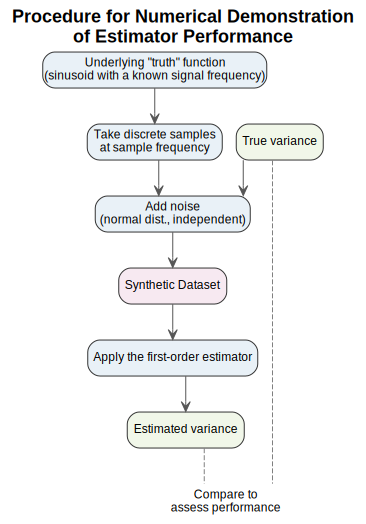

In [6]:
g = graphviz.Digraph(**gv_settings)
var_style = dict(fillcolor='#F1F7E9')

g.attr(
    label="Procedure for Numerical Demonstration\nof Estimator Performance",
    labelloc="t",
    fontname='Helvetica-Bold', fontsize='18', shape='plaintext'
)

g.node("func", label="Underlying \"truth\" function\n(sinusoid with a known signal frequency)")
g.node("draw", label="Take discrete samples\nat sample frequency")
g.edge("func", "draw")

g.node("tvar", label="True variance", **var_style)
g.node("noise", label="Add noise\n(normal dist., independent)")
g.edge("tvar", "noise")

g.edge("draw", "noise")

g.node("syn", label="Synthetic Dataset", fillcolor='#F7E9F1')
g.edge("noise", "syn")

g.node("est", label="Apply the first-order estimator")
g.node("evar", label="Estimated variance", **var_style)

g.edge("syn", "est")
g.edge("est", "evar")

g.node("c", label="Compare to\nassess performance", shape='plaintext', fillcolor="white")

dashed_line = dict(
    style='dashed',
    color='gray',
    arrowhead='none',
    arrowtail='none',
    dir='both',
    penwidth='1',
)
g.edge("tvar", "c", **dashed_line)
g.edge("evar", "c", **dashed_line)

g

In code:

In [7]:
np.random.seed(0)  # Sets a pseudo-random seed for reproducibility


def synthesize_data_and_reconstruct_noise_variance_1(freq_signal, freq_sample):
    """
    Generates a synthetic dataset with known noise properties, and then reconstructs the noise variance using the
    first-order method described above.

    The signal is assumed to be a sinusoid with some frequency, and the noise is assumed to be independent,
    homoscedastic, and normally-distributed.

    Args:
        freq_signal: Frequency of the underlying true signal [Hz]
        freq_sample: Data sample rate from the sensor [Hz]

    Returns: None. Prints the true noise standard deviation and the reconstructed (estimated) noise standard
    deviation, as well as various input parameters.
    """
    ##### Synthetic Data Generation #####
    t = np.arange(0, 5, 1 / freq_sample)

    true_data = np.sin(2 * np.pi * freq_signal * t)

    true_noise_standard_deviation = 0.1
    noise = np.random.normal(size=len(true_data)) * true_noise_standard_deviation

    sensor_data = true_data + noise

    ##### Noise Variance Reconstruction #####
    estimated_noise_standard_deviation = (
            np.std(  # Standard deviation
                np.diff(sensor_data)  # of the differences between subsequent samples
            ) / np.sqrt(2)
    )

    print(f"First-Order Data-Driven Noise Estimator")
    print(f"Sample frequency / Underlying Signal Frequency = {1 / np.diff(t)[0]}")
    print("-" * 50)
    print(f"True noise standard deviation: {true_noise_standard_deviation:.3f}")
    print(f"Estimated noise standard deviation: {estimated_noise_standard_deviation:.3f}")

In [8]:
synthesize_data_and_reconstruct_noise_variance_1(
    freq_signal=1,
    freq_sample=1000
)

First-Order Data-Driven Noise Estimator
Sample frequency / Underlying Signal Frequency = 1000.0
--------------------------------------------------
True noise standard deviation: 0.100
Estimated noise standard deviation: 0.098


As we can see, noise standard deviation that we estimate using this method is very close to the true value. We will also show later that this estimator is convergent to the true value as the number of samples increases.

However, this estimator is only first-order convergent with respect to the ratio between the sampling frequency (`freq_sample`) and the underlying dynamics of the system (`freq_signal`). In other words, if the system is "fast" relative to the sample rate, then the estimator will be inaccurate. We can demonstrate this by repeating the above experiment, but with a higher-frequency true signal:

In [9]:
synthesize_data_and_reconstruct_noise_variance_1(
    freq_signal=100,
    freq_sample=1000
)

First-Order Data-Driven Noise Estimator
Sample frequency / Underlying Signal Frequency = 1000.0
--------------------------------------------------
True noise standard deviation: 0.100
Estimated noise standard deviation: 0.324


Notably, the discrepancy between the true and estimated noise standard deviations are much larger, so our first-order estimator is not working as well.

#### A Second-Order Estimator

To do a better job of estimating the noise variance even in cases where $f_{\rm sample} \gg f_{\rm signal}$ doesn't strictly hold, we can use a second-order estimator. With this extension, we use a three-point numerical stencil.

Derivation of this estimator follows similar principles to the first-order estimator above, with the key result as follows:

$$\sigma^2 = \frac{1}{6 \cdot (N-2)} \sum_{i=1}^{N-2} \Big( s(t_{i+2}) - 2 \cdot s(t_{i+1}) + s(t_i) \Big)^2$$

where $N$ is the number of samples in the dataset.

Notably, this effectively implements a first-order, second-degree finite-difference of the underlying data - a discrete derivative. It's instructive to consider the theoretical underpinning of using a discrete derivative operator here. If we assume that the underlying true signal is relatively smooth, then as we take more discrete derivatives of the observed data, the signal component will asymptote to zero (assuming $f_{\rm sample} \geq f_{\rm signal}$). Stated equivalently, the frequency spectrum of the true signal is assumed to have some cutoff frequency (analogous to $f_{\rm signal}$), above which the power spectral density gradually goes to zero. We don't need to specify this cutoff frequency or know it precisely *a priori*; the remarks presented here merely require that one exists and is somewhere below $f_{\rm sample}$.

In contrast, the noise is assumed to be independent, which means that the noise component of the observed data will *not* go to zero as we take successive derivatives. Stated equivalently, the frequency spectrum of the noise is *white*, with uniform power across all frequencies. Therefore, **repeated application of the discrete derivative operator acts as a way to spectrally-separate the noise from the signal**. This is a key insight that we will use later in the paper.

In code, this second-order estimator would look like the following:

In [10]:
def synthesize_data_and_reconstruct_noise_variance_2(freq_signal, freq_sample):
    """
    Generates a synthetic dataset with known noise properties, and then reconstructs the noise variance using the
    second-order method described above.

    The signal is assumed to be a sinusoid with some frequency, and the noise is assumed to be independent,
    homoscedastic, and normally-distributed.

    Args:
        freq_signal: Frequency of the underlying true signal [Hz]
        freq_sample: Data sample rate from the sensor [Hz]

    Returns: None. Prints the true noise standard deviation and the reconstructed (estimated) noise standard
    deviation, as well as various input parameters.
    """
    ##### Synthetic Data Generation #####
    t = np.arange(0, 5, 1 / freq_sample)

    true_data = np.sin(2 * np.pi * freq_signal * t)

    true_noise_standard_deviation = 0.1
    noise = np.random.normal(size=len(true_data)) * true_noise_standard_deviation

    sensor_data = true_data + noise

    ##### Noise Variance Reconstruction #####
    estimated_noise_standard_deviation = (
            np.std(  # Standard deviation
                np.diff(np.diff(sensor_data))  # of the differences between subsequent samples
            ) / np.sqrt(6)
    )

    print(f"Second-Order Data-Driven Noise Estimator")
    print(f"Sample frequency / Underlying Signal Frequency = {1 / np.diff(t)[0]}")
    print("-" * 50)
    print(f"True noise standard deviation: {true_noise_standard_deviation:.3f}")
    print(f"Estimated noise standard deviation: {estimated_noise_standard_deviation:.3f}")

This second-order estimator is still convergent when we have a wealth of samples (i.e., the system is "slow" relative to the sample rate):

In [11]:
synthesize_data_and_reconstruct_noise_variance_2(
    freq_signal=1,
    freq_sample=1000
)

Second-Order Data-Driven Noise Estimator
Sample frequency / Underlying Signal Frequency = 1000.0
--------------------------------------------------
True noise standard deviation: 0.100
Estimated noise standard deviation: 0.099


But, in comparison, its performance drop-off for "fast" systems is much less severe than it is for the first-order estimator:

In [12]:
synthesize_data_and_reconstruct_noise_variance_2(
    freq_signal=100,
    freq_sample=1000
)

Second-Order Data-Driven Noise Estimator
Sample frequency / Underlying Signal Frequency = 1000.0
--------------------------------------------------
True noise standard deviation: 0.100
Estimated noise standard deviation: 0.148


#### Arbitrary-Order Estimators

Clearly, the second-order estimator improves performance compared to the first-order one. How far can we push this?

We can generalize the logic to an $d$-th order estimator by observing that the denominator (2 for the first-order estimator, 6 for the second-order estimator) is the sum of the squares of the first-order, $d$-th-degree, uniform-grid finite difference coefficients (or, perhaps more intuitively, the elements of the $d$-th row of Pascal's triangle). Then, we use the combinatorial trick that:

$${d \choose 0}^2 + {d \choose 1}^2 + \dots + {d \choose d}^2 = {2 d \choose d} = \frac{(2d)!}{(d!)^2}$$

to derive the following $d$-th order estimator of the noise variance:

$$\sigma^2 =
\frac{1}{{2 d \choose d} \cdot (N-d)}
\cdot \sum_{i=1}^{N-d} \left[
{d \choose 0} s(t_i)
- {d \choose 1} s(t_{i+1})
+ {d \choose 2} s(t_{i+2})
- {d \choose 3} s(t_{i+3})
+ \dots
\pm {d \choose d} s(t_{i+d})
\right]^2$$

which, in code, looks like:

In [13]:
def synthesize_data_and_reconstruct_noise_variance(freq_signal, freq_sample, order=1):
    """
    Generates a synthetic dataset with known noise properties, and then reconstructs the noise variance using the
    specified-order method described above.

    The signal is assumed to be a sinusoid with some frequency, and the noise is assumed to be independent,
    homoscedastic, and normally-distributed.

    Args:
        freq_signal: Frequency of the underlying true signal [Hz]
        freq_sample: Data sample rate from the sensor [Hz]
        order: Order of the estimator to use [int]

    Returns: The true noise standard deviation and the reconstructed (estimated) noise standard deviation.
    """
    ##### Synthetic Data Generation #####
    t = np.arange(0, 5, 1 / freq_sample)

    true_data = np.sin(2 * np.pi * freq_signal * t)

    true_noise_standard_deviation = 0.1
    noise = np.random.normal(size=len(true_data)) * true_noise_standard_deviation

    sensor_data = true_data + noise

    ##### Noise Variance Reconstruction #####
    ### Note: there are a few differences between the equation above and this, to prevent overflow
    diff_data = sensor_data

    from scipy.special import binom
    denominator = np.sqrt(binom(2 * order, order))

    for _ in range(order):
        diff_data = np.diff(diff_data) / denominator ** (1 / order)

    estimated_noise_standard_deviation = np.std(diff_data)

    return true_noise_standard_deviation, estimated_noise_standard_deviation

Then, we can plot the performance of noise estimators of various orders. Interestingly, we can crank up the order of the estimator incredibly high (until we hit floating-point overflow) and still get a good estimator:

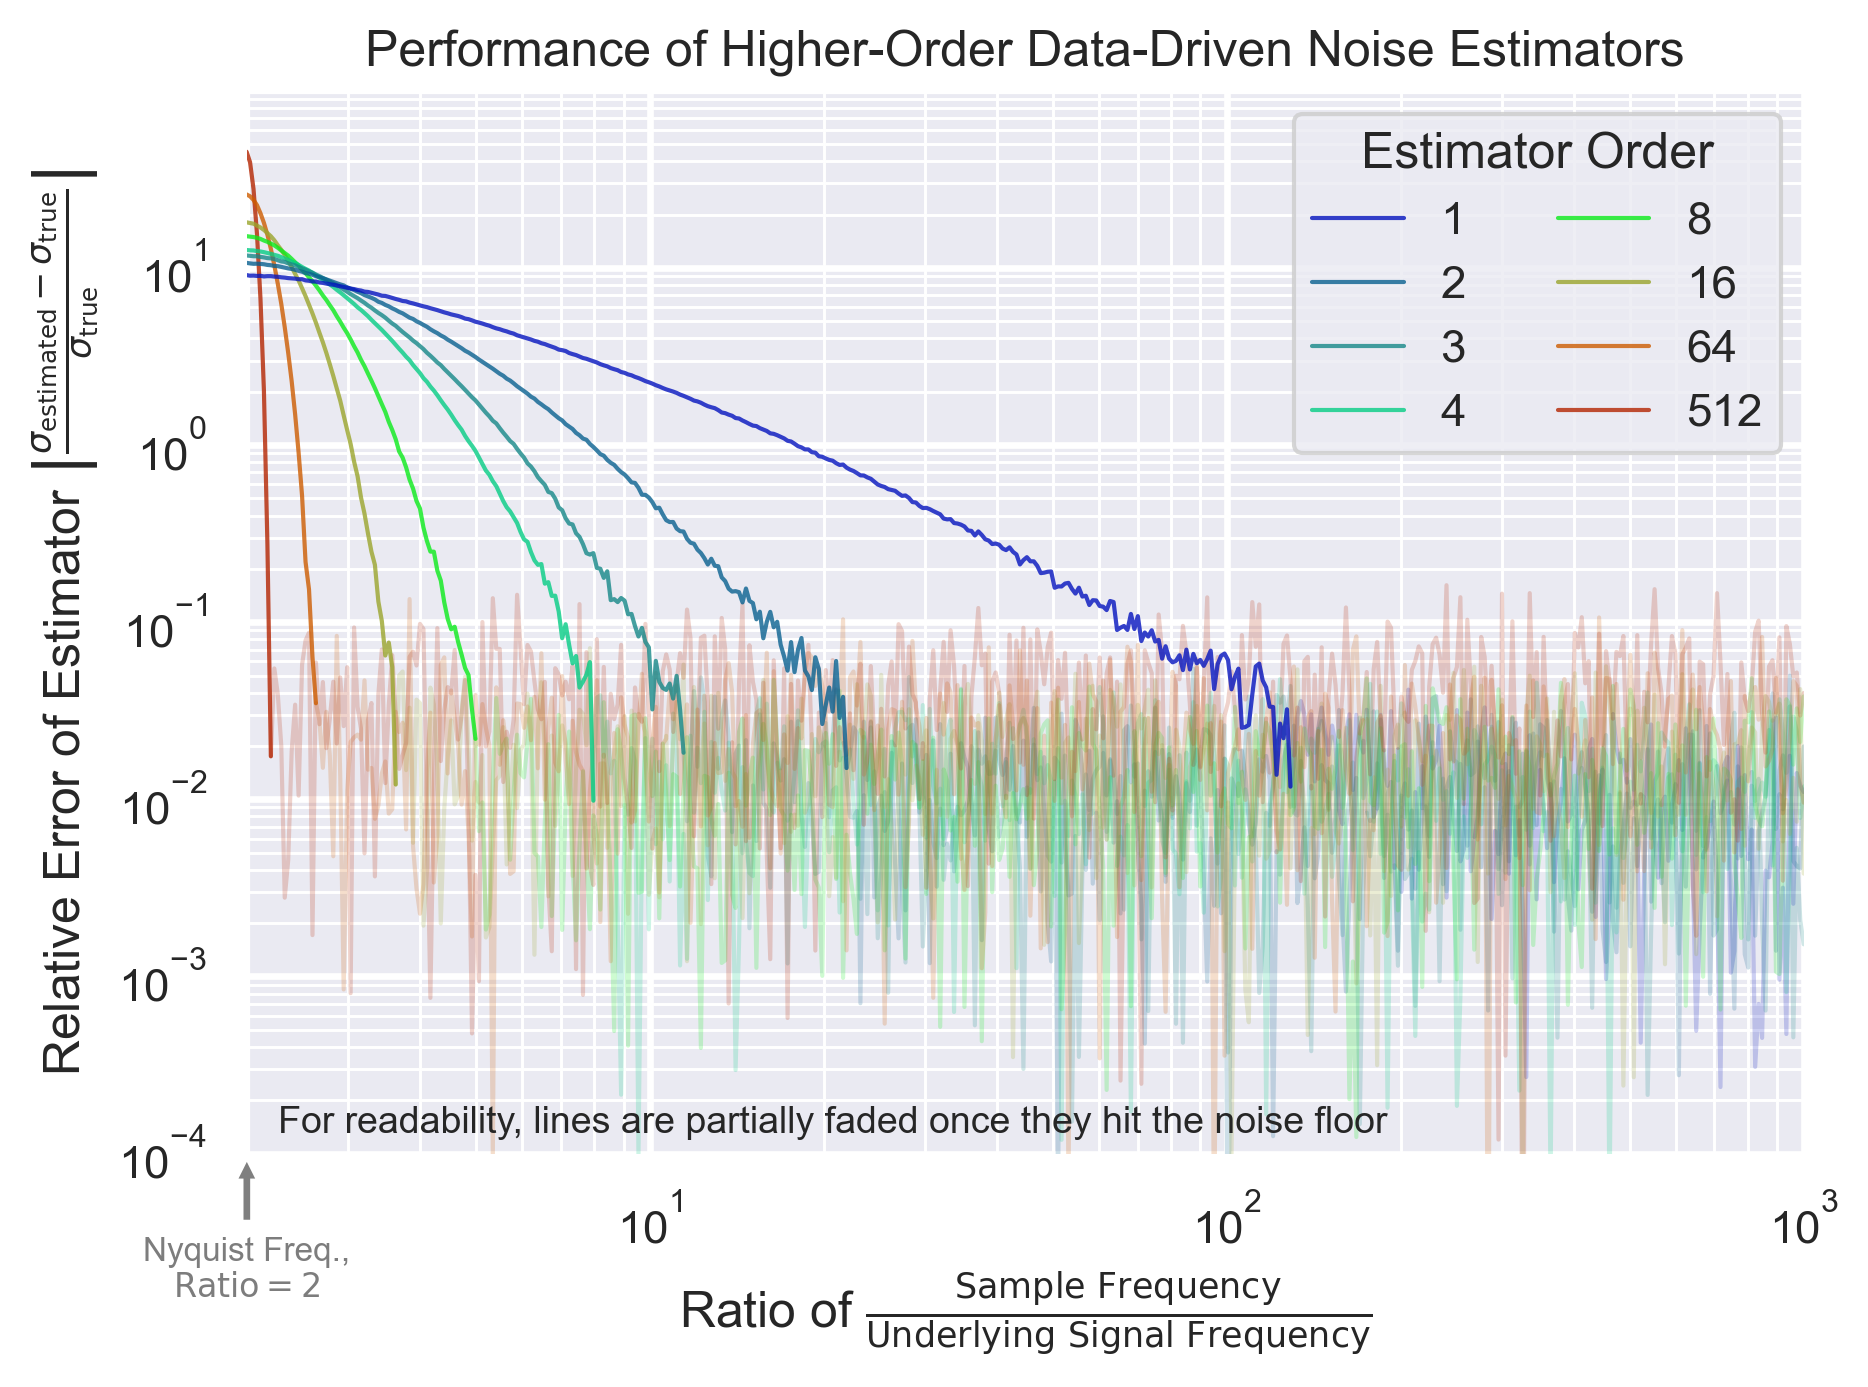

In [14]:
fig, ax = plt.subplots()

freq_sample = 1000
freq_signals = freq_sample / np.logspace(0, 3, 500)
orders = [1, 2, 3, 4, 8, 16, 64, 512]

colors = p.sns.color_palette('rainbow', n_colors=len(orders))

for i, order in enumerate(orders):
    true, estimated = np.vectorize(synthesize_data_and_reconstruct_noise_variance)(
        freq_signal=freq_signals,
        freq_sample=freq_sample,
        order=order,
    )
    ratio = freq_sample / freq_signals
    error = np.abs(true - estimated) / true

    index_noise_floor = np.argwhere(
        (np.arange(len(error)) > np.argmax(error)) & (error < 2 * np.median(error[-50:]))
    )[0][0]

    c = p.adjust_lightness(colors[i], 0.6)

    # print(order)
    # print(np.mean(estimated[index_noise_floor+1:]), np.std(estimated[index_noise_floor+1:]))

    ax.loglog(
        ratio[:index_noise_floor + 1],
        error[:index_noise_floor + 1],
        label=f"{order}",
        alpha=0.8, color=c, linewidth=1,
        zorder=4 + len(orders) - i,
    )
    ax.loglog(
        ratio[index_noise_floor:],
        error[index_noise_floor:],
        alpha=0.2, color=c, linewidth=1,
        zorder=3,
    )

plt.xlim(left=2, right=(freq_sample / freq_signals)[-1])
plt.ylim(bottom=1 / freq_sample / 10)

plt.annotate(
    text="Nyquist Freq.,\n$\mathrm{Ratio}=2$",
    xy=(0, 0),
    xytext=(0, -20),
    xycoords="axes fraction",
    textcoords="offset points",
    ha="center",
    va="top",
    alpha=0.6,
    fontsize=8,
    arrowprops=dict(
        arrowstyle="simple",
        # connectionstyle="arc3,rad=0.2",
        linewidth=0,
        alpha=0.5,
        facecolor="k",
    ),
)
plt.annotate(
    text="For readability, lines are partially faded once they hit the noise floor",
    xy=(0.02, 0.02),
    xycoords="axes fraction",
    ha="left",
    fontsize=9
)

plt.legend(
    title="Estimator Order",
    ncols=2,
)
p.show_plot(
    title="Performance of Higher-Order Data-Driven Noise Estimators",
    xlabel=r"Ratio of $\frac{\mathrm{Sample\ Frequency}}{\mathrm{Underlying\ Signal\ Frequency}}$",
    ylabel=r"Relative Error of Estimator $\left| \frac{ \sigma_{\mathrm{estimated}} - \sigma_{\mathrm{true}} }{\sigma_{\mathrm{true}}}\right|$",
    legend=False,
    dpi=300,
)

In fact, from a practical perspective, estimator performance seems to monotonically improve with increasing estimator order, with the 512-th-order estimator able to recover an accurate estimate of the amount of sensor noise even when the frequency of the underlying signal and the sample rate are within 20% of the Nyquist frequency - i.e., almost aliasing.